### 모듈 가져오기

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/Othercomputers/내 노트북/07_PJT_final_01/01_clothes_classification

/content/drive/Othercomputers/내 노트북/07_PJT_final_01/01_clothes_classification


In [ ]:
img_size = 224
channel=3

In [ ]:
train_datagen = ImageDataGenerator( 
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        rotation_range=40,      # 40도까지 회전
        width_shift_range=0.2,  # 20%까지 좌우 이동
        height_shift_range=0.2, # 20%까지 상하 이동
        shear_range=0.2,        # 20%까지 기울임
        zoom_range=0.2,         # 20%까지 확대
        horizontal_flip=True,   # 좌우 뒤집기
    )
train_generator = train_datagen.flow_from_directory(
    './dataset/Train',
    batch_size=200,      
    class_mode='categorical', 
    target_size=(img_size, img_size)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory(
    './dataset/Validation',
    batch_size=80,      
    class_mode='categorical', 
    target_size=(img_size, img_size))
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory(
    './dataset/test',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(img_size, img_size),
    shuffle=False)

Found 32426 images belonging to 4 classes.
Found 7854 images belonging to 4 classes.
Found 278 images belonging to 4 classes.


In [ ]:
print('train_generator class : ', train_generator.class_indices)
print('valid_generator class : ', valid_generator.class_indices)
print('test_generator class : ', test_generator.class_indices)

train_generator class :  {'bottoms': 0, 'one-piece': 1, 'outerwear': 2, 'tops': 3}
valid_generator class :  {'bottoms': 0, 'one-piece': 1, 'outerwear': 2, 'tops': 3}
test_generator class :  {'bottoms': 0, 'one-piece': 1, 'outerwear': 2, 'tops': 3}


### 모델 학습하기 - MobileNetV2
- imagenet 전이학습
- 은닉층
   * Flatten(input_shape=(112,112))
   * Dense(224, activation='relu')
   * Dropout(0.2)
- 출력층
   * Dense(4, activation='softmax')


In [ ]:
# 파라미터 설정
classes = len(train_generator.class_indices)

In [ ]:
MobileNet = tf.keras.applications.MobileNetV3Large(weights='imagenet',
                                              include_top=False, 
                                              input_shape=(img_size, img_size, 3))
MobileNet.trainable = False # 학습으로 기존 가중치 갱신을 하지 않도록 지정

12697600/12683000 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(MobileNet)
model.add(Flatten(input_shape=(112,112)))
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 47040)             0         
                                                                 
 dense (Dense)               (None, 224)               10537184  
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 900       
                                                                 
Total params: 13,534,436
Trainable params: 10,538,084
Non-trainable params: 2,996,352
____________________________________

In [ ]:
# 모델 환경설정
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_name = './model/MobileNetV2_05_{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_loss',save_best_only=True) # 성능이 개선될떄만 저장하도록
earlystopping = EarlyStopping(monitor='val_loss', patience=10) # 10번동안 성능개선이 없으면 학습 조기종료

In [ ]:
history = model.fit(train_generator,
                    epochs=500,
                    validation_data=valid_generator, 
                    callbacks = [[earlystopping, checkpointer]]) 

Epoch 1/500
163/163 [==============================] - 20452s 125s/step - loss: 1.2893 - accuracy: 0.6169 - val_loss: 0.9411 - val_accuracy: 0.6604
Epoch 2/500
163/163 [==============================] - 1051s 6s/step - loss: 0.9137 - accuracy: 0.6705 - val_loss: 0.8424 - val_accuracy: 0.6981
Epoch 3/500
163/163 [==============================] - 1036s 6s/step - loss: 0.8925 - accuracy: 0.6749 - val_loss: 0.8276 - val_accuracy: 0.6928
Epoch 4/500
163/163 [==============================] - 1136s 7s/step - loss: 0.8810 - accuracy: 0.6784 - val_loss: 0.8064 - val_accuracy: 0.6868
Epoch 5/500
163/163 [==============================] - 1142s 7s/step - loss: 0.8773 - accuracy: 0.6840 - val_loss: 0.7814 - val_accuracy: 0.7023
Epoch 6/500
163/163 [==============================] - 1118s 7s/step - loss: 0.8780 - accuracy: 0.6790 - val_loss: 0.7605 - val_accuracy: 0.7126
Epoch 7/500
163/163 [==============================] - 1166s 7s/step - loss: 0.8589 - accuracy: 0.6863 - val_loss: 0.7324 - val

In [ ]:
max(history.history['accuracy'])

0.6989144682884216

In [ ]:
# 모델 저장
accuracy = round(max(history.history['accuracy'])*100,0)
model.save(f'./model/MobileNetV3Large_05_model_acc{accuracy}.h5') # 최종 모델 저장

In [ ]:
Y_pred = model.predict(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=1) 

result_dict = dict(map(reversed, test_generator.class_indices.items()))
class_names = list(result_dict.values())

print('-- Confusion Matrix --')
print(confusion_matrix(classes, y_pred))

print('-- Classification Report --')
print(classification_report(classes, y_pred, target_names=class_names))


-- Confusion Matrix --
[[19  0  0 51]
 [14 16  0 39]
 [ 3  3  0 63]
 [ 6  3  0 61]]
-- Classification Report --
              precision    recall  f1-score   support

     bottoms       0.45      0.27      0.34        70
   one-piece       0.73      0.23      0.35        69
   outerwear       0.00      0.00      0.00        69
        tops       0.29      0.87      0.43        70

    accuracy                           0.35       278
   macro avg       0.37      0.34      0.28       278
weighted avg       0.37      0.35      0.28       278



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


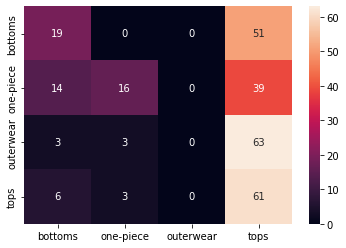

In [ ]:
sns.heatmap(confusion_matrix(classes, y_pred), annot=True, fmt='d',
            xticklabels=['bottoms', 'one-piece', 'outerwear', 'tops'] ,
            yticklabels=['bottoms', 'one-piece', 'outerwear', 'tops'] )

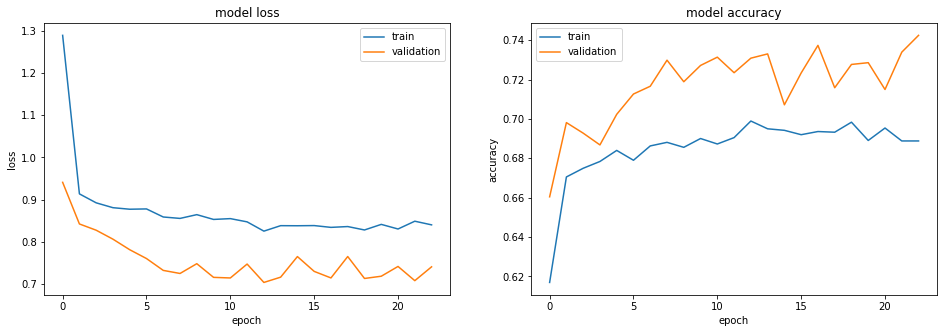

In [ ]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

In [ ]:
model.evaluate(test_generator)

In [ ]:
train_generator.class_indices

{'bottoms': 0, 'one-piece': 1, 'outerwear': 2, 'tops': 3}

In [ ]:
# 구글에 올려진 실제 이미지로 예측 결과 확인

class_dict = {0:'bottoms', 1:'one-piece', 2:'outerwear', 3:'tops'}

fig = plt.figure(figsize=(12,12))
i=0
for img in glob.glob('./dataset/test/*.jpg'):
    ax = plt.subplot(4,4,i+1) 
    test_img = cv2.imread(img)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))/255.0
    test_img_input = test_img.reshape((1,)+test_img.shape)
    pred = model.predict(test_img_input)
    pred_class = class_dict[np.argmax(pred, axis=1)[0]]
    ax.imshow(test_img)
    ax.axis('off')
    ax.set_title(f'{pred_class}',fontsize=17)
    i += 1
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.7, wspace=0.2, hspace=0.2)
plt.show()

<Figure size 864x864 with 0 Axes>

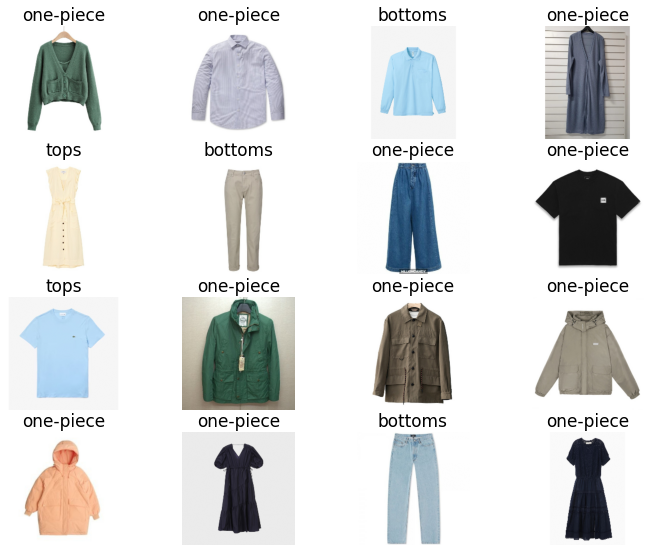

In [ ]:
# 구글에 올려진 실제 이미지로 예측 결과 확인

class_dict = {0:'bottoms', 1:'one-piece', 2:'outerwear', 3:'tops'}

fig = plt.figure(figsize=(12,12))
i=0
for img in glob.glob('./dataset/test2/*.jpg'):
    ax = plt.subplot(4,4,i+1) 
    test_img = cv2.imread(img)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))/255.0
    test_img_input = test_img.reshape((1,)+test_img.shape)
    pred = model.predict(test_img_input)
    pred_class = class_dict[np.argmax(pred, axis=1)[0]]
    ax.imshow(test_img)
    ax.axis('off')
    ax.set_title(f'{pred_class}',fontsize=17)
    i += 1
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.7, wspace=0.2, hspace=0.2)
plt.show()

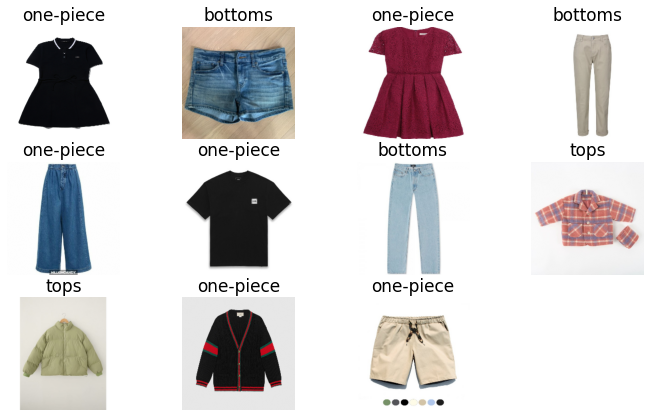

In [ ]:
# 구글에 올려진 실제 이미지로 예측 결과 확인

class_dict = {0:'bottoms', 1:'one-piece', 2:'outerwear', 3:'tops'}

fig = plt.figure(figsize=(12,12))
i=0
for img in glob.glob('./dataset/test3/*.jpg'):
    ax = plt.subplot(4,4,i+1) 
    test_img = cv2.imread(img)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))/255.0
    test_img_input = test_img.reshape((1,)+test_img.shape)
    pred = model.predict(test_img_input)
    pred_class = class_dict[np.argmax(pred, axis=1)[0]]
    ax.imshow(test_img)
    ax.axis('off')
    ax.set_title(f'{pred_class}',fontsize=17)
    i += 1
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.7, wspace=0.2, hspace=0.2)
plt.show()